In [1]:
"""
[V1]
* Add Max./Min. Channels

[TODO]
* Separate gene expression, cell vaibility and other features
* PCGrad (Project Conflicting Gradients)
* Tuning resolution and image size

ResNeSt:
https://github.com/zhanghang1989/ResNeSt
"""

kernel_mode = False
training_mode = True

import sys
if kernel_mode:
    sys.path.insert(0, "../input/iterative-stratification")
    sys.path.insert(0, "../input/pytorch-lightning")
    sys.path.insert(0, "../input/resnest")
    sys.path.insert(0, "../input/pytorch-optimizer")
    sys.path.insert(0, "../input/pytorch-ranger")

import os
import numpy as np
import pandas as pd
import time
import random
import math
import pickle
from pickle import dump, load
import glob

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.cm import get_cmap
from matplotlib import rcParams

import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, \
    RobustScaler, QuantileTransformer, PowerTransformer
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE

from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F
from torch.autograd import Function
import torch.optim as optim
from torch.nn import Linear, BatchNorm1d, ReLU
from torchvision import transforms

import torch_optimizer

import pytorch_lightning as pl
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.metrics.functional import classification

import resnest
from resnest.torch import resnest50, resnest101, resnest200, resnest269, \
    resnest50_fast_2s2x40d, resnest50_fast_1s2x40d, resnest50_fast_1s1x64d

import cv2
import imgaug as ia
from imgaug.augmenters.size import CropToFixedSize

import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_columns = None
sns.set(style="darkgrid")

import gc
gc.enable()

rand_seed = 1120

print(f"PyTorch Version: {torch.__version__}")
print(f"PyTorch Lightning Version: {pl.__version__}")

PyTorch Version: 1.6.0+cu101
PyTorch Lightning Version: 1.0.4


In [2]:
# if kernel_mode:
#     !mkdir -p /root/.cache/torch/hub/checkpoints/
#     !cp ../input/deepinsight-resnest-v1-resnest50/*.pth /root/.cache/torch/hub/checkpoints/
#     !ls -la /root/.cache/torch/hub/checkpoints/

In [3]:
model_type = "resnest50"
pretrained_model = f"resnest50_fast_2s2x40d"
experiment_name = f"deepinsight_ResNeSt_v1_{model_type}_drug_id"

if kernel_mode:
    dataset_folder = "../input/lish-moa"
    model_output_folder = f"./{experiment_name}" if training_mode \
        else f"../input/deepinsight-resnest-v1-resnest50/{experiment_name}"
else:
    dataset_folder = "/workspace/Kaggle/MoA"
    model_output_folder = f"{dataset_folder}/{experiment_name}" if training_mode \
        else f"/workspace/Kaggle/MoA/completed/deepinsight_ResNeSt_v1_resnest50/{experiment_name}"

if training_mode:
    os.makedirs(model_output_folder, exist_ok=True)

    # Dedicated logger for experiment
    exp_logger = TensorBoardLogger(model_output_folder,
                                   name=f"overall_logs",
                                   default_hp_metric=False)

# debug_mode = True
debug_mode = False

num_workers = 2 if kernel_mode else 6
# gpus = [1]
# gpus = [0, 1]
# gpus = [0]
gpus = [1]

epochs = 200
patience = 16

# learning_rate = 1e-3
learning_rate = 0.000352  # Suggested Learning Rate from LR finder (V7)
learning_rate *= len(gpus)
weight_decay = 1e-6
# weight_decay = 0

# T_max = 10  # epochs
T_max = 5  # epochs
T_0 = 5  # epochs

accumulate_grad_batches = 1
gradient_clip_val = 10.0

if "resnest50" in model_type:
    batch_size = 128
    infer_batch_size = 256 if not kernel_mode else 256
    image_size = 224
    resolution = 224
elif model_type == "resnest101":
    batch_size = 48
    infer_batch_size = 96
    image_size = 256
    resolution = 256
elif model_type == "resnest200":
    batch_size = 12
    infer_batch_size = 24
    image_size = 320
    resolution = 320
elif model_type == "resnest269":
    batch_size = 4
    infer_batch_size = 8
    image_size = 416
    resolution = 416

# Prediction Clipping Thresholds
prob_min = 0.001
prob_max = 0.999

# Swap Noise
swap_prob = 0.1
swap_portion = 0.15

label_smoothing = 0.001

# DeepInsight Transform
perplexity = 5

fc_size = 512

final_drop = 0.0
dropblock_prob = 0.0

In [4]:
train_features = pd.read_csv(
    f"{dataset_folder}/train_features.csv", engine='c')
train_labels = pd.read_csv(
    f"{dataset_folder}/train_targets_scored.csv", engine='c')

train_extra_labels = pd.read_csv(
    f"{dataset_folder}/train_targets_nonscored.csv", engine='c')

test_features = pd.read_csv(
    f"{dataset_folder}/test_features.csv", engine='c')

sample_submission = pd.read_csv(
    f"{dataset_folder}/sample_submission.csv", engine='c')

In [5]:
# Sort by sig_id to ensure that all row orders match
train_features = train_features.sort_values(
    by=["sig_id"], axis=0, inplace=False).reset_index(drop=True)
train_labels = train_labels.sort_values(by=["sig_id"], axis=0,
                                        inplace=False).reset_index(drop=True)
train_extra_labels = train_extra_labels.sort_values(
    by=["sig_id"], axis=0, inplace=False).reset_index(drop=True)

sample_submission = sample_submission.sort_values(
    by=["sig_id"], axis=0, inplace=False).reset_index(drop=True)

In [6]:
train_features.shape, train_labels.shape, train_extra_labels.shape

((23814, 876), (23814, 207), (23814, 403))

In [7]:
test_features.shape

(3982, 876)

## Include Drug ID

In [8]:
train_drug = pd.read_csv(f"{dataset_folder}/train_drug.csv", engine='c')
train_features = train_features.merge(train_drug, on='sig_id', how='left')

In [9]:
category_features = ["cp_type", "cp_dose"]
numeric_features = [
    c for c in train_features.columns
    if c not in ["sig_id", "drug_id"] and c not in category_features
]
all_features = category_features + numeric_features
gene_experssion_features = [c for c in numeric_features if c.startswith("g-")]
cell_viability_features = [c for c in numeric_features if c.startswith("c-")]
len(numeric_features), len(gene_experssion_features), len(
    cell_viability_features)

(873, 772, 100)

In [10]:
train_classes = [c for c in train_labels.columns if c != "sig_id"]
train_extra_classes = [c for c in train_extra_labels.columns if c != "sig_id"]
len(train_classes), len(train_extra_classes)

(206, 402)

## Drop Control Type Rows

In [11]:
train_features = train_features[train_features["cp_type"] == "trt_cp"].copy()
train_labels = train_labels.iloc[train_features.index, :].copy()
train_extra_labels = train_extra_labels.iloc[train_features.index, :].copy()

train_features = train_features.reset_index(drop=True)
train_labels = train_labels.reset_index(drop=True)
train_extra_labels = train_extra_labels.reset_index(drop=True)

In [12]:
train_features.shape, train_labels.shape, train_extra_labels.shape

((21948, 877), (21948, 207), (21948, 403))

## Label Encoding

In [13]:
for df in [train_features, test_features]:
    df['cp_type'] = df['cp_type'].map({'ctl_vehicle': 0, 'trt_cp': 1})
    df['cp_dose'] = df['cp_dose'].map({'D1': 0, 'D2': 1})
    df['cp_time'] = df['cp_time'].map({24: 0, 48: 0.5, 72: 1})

In [14]:
train_features["cp_type"].value_counts()

1    21948
Name: cp_type, dtype: int64

In [15]:
train_features["cp_dose"].value_counts()

0    11196
1    10752
Name: cp_dose, dtype: int64

In [16]:
train_features["cp_time"].value_counts()

0.5    7602
1.0    7180
0.0    7166
Name: cp_time, dtype: int64

## DeepInsight Transform (t-SNE)
Based on https://github.com/alok-ai-lab/DeepInsight, but with some minor corrections

### Implementation

In [17]:
# Modified from DeepInsight Transform
# https://github.com/alok-ai-lab/DeepInsight/blob/master/pyDeepInsight/image_transformer.py

import numpy as np
import pandas as pd
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE
from scipy.spatial import ConvexHull
from matplotlib import pyplot as plt
import inspect


class DeepInsightTransformer:
    """Transform features to an image matrix using dimensionality reduction

    This class takes in data normalized between 0 and 1 and converts it to a
    CNN compatible 'image' matrix

    """
    def __init__(self,
                 feature_extractor='tsne',
                 perplexity=30,
                 pixels=100,
                 random_state=None,
                 n_jobs=None):
        """Generate an ImageTransformer instance

        Args:
            feature_extractor: string of value ('tsne', 'pca', 'kpca') or a
                class instance with method `fit_transform` that returns a
                2-dimensional array of extracted features.
            pixels: int (square matrix) or tuple of ints (height, width) that
                defines the size of the image matrix.
            random_state: int or RandomState. Determines the random number
                generator, if present, of a string defined feature_extractor.
            n_jobs: The number of parallel jobs to run for a string defined
                feature_extractor.
        """
        self.random_state = random_state
        self.n_jobs = n_jobs

        if isinstance(feature_extractor, str):
            fe = feature_extractor.casefold()
            if fe == 'tsne_exact'.casefold():
                fe = TSNE(n_components=2,
                          metric='cosine',
                          perplexity=perplexity,
                          n_iter=1000,
                          method='exact',
                          random_state=self.random_state,
                          n_jobs=self.n_jobs)
            elif fe == 'tsne'.casefold():
                fe = TSNE(n_components=2,
                          metric='cosine',
                          perplexity=perplexity,
                          n_iter=1000,
                          method='barnes_hut',
                          random_state=self.random_state,
                          n_jobs=self.n_jobs)
            elif fe == 'pca'.casefold():
                fe = PCA(n_components=2, random_state=self.random_state)
            elif fe == 'kpca'.casefold():
                fe = KernelPCA(n_components=2,
                               kernel='rbf',
                               random_state=self.random_state,
                               n_jobs=self.n_jobs)
            else:
                raise ValueError(("Feature extraction method '{}' not accepted"
                                  ).format(feature_extractor))
            self._fe = fe
        elif hasattr(feature_extractor, 'fit_transform') and \
                inspect.ismethod(feature_extractor.fit_transform):
            self._fe = feature_extractor
        else:
            raise TypeError('Parameter feature_extractor is not a '
                            'string nor has method "fit_transform"')

        if isinstance(pixels, int):
            pixels = (pixels, pixels)

        # The resolution of transformed image
        self._pixels = pixels
        self._xrot = None

    def fit(self, X, y=None, plot=False):
        """Train the image transformer from the training set (X)

        Args:
            X: {array-like, sparse matrix} of shape (n_samples, n_features)
            y: Ignored. Present for continuity with scikit-learn
            plot: boolean of whether to produce a scatter plot showing the
                feature reduction, hull points, and minimum bounding rectangle

        Returns:
            self: object
        """
        # Transpose to get (n_features, n_samples)
        X = X.T

        # Perform dimensionality reduction
        x_new = self._fe.fit_transform(X)

        # Get the convex hull for the points
        chvertices = ConvexHull(x_new).vertices
        hull_points = x_new[chvertices]

        # Determine the minimum bounding rectangle
        mbr, mbr_rot = self._minimum_bounding_rectangle(hull_points)

        # Rotate the matrix
        # Save the rotated matrix in case user wants to change the pixel size
        self._xrot = np.dot(mbr_rot, x_new.T).T

        # Determine feature coordinates based on pixel dimension
        self._calculate_coords()

        # plot rotation diagram if requested
        if plot is True:
            # Create subplots
            fig, ax = plt.subplots(1, 1, figsize=(10, 7), squeeze=False)
            ax[0, 0].scatter(x_new[:, 0],
                             x_new[:, 1],
                             cmap=plt.cm.get_cmap("jet", 10),
                             marker="x",
                             alpha=1.0)
            ax[0, 0].fill(x_new[chvertices, 0],
                          x_new[chvertices, 1],
                          edgecolor='r',
                          fill=False)
            ax[0, 0].fill(mbr[:, 0], mbr[:, 1], edgecolor='g', fill=False)
            plt.gca().set_aspect('equal', adjustable='box')
            plt.show()
        return self

    @property
    def pixels(self):
        """The image matrix dimensions

        Returns:
            tuple: the image matrix dimensions (height, width)

        """
        return self._pixels

    @pixels.setter
    def pixels(self, pixels):
        """Set the image matrix dimension

        Args:
            pixels: int or tuple with the dimensions (height, width)
            of the image matrix

        """
        if isinstance(pixels, int):
            pixels = (pixels, pixels)
        self._pixels = pixels
        # recalculate coordinates if already fit
        if hasattr(self, '_coords'):
            self._calculate_coords()

    def _calculate_coords(self):
        """Calculate the matrix coordinates of each feature based on the
        pixel dimensions.
        """
        ax0_coord = np.digitize(self._xrot[:, 0],
                                bins=np.linspace(min(self._xrot[:, 0]),
                                                 max(self._xrot[:, 0]),
                                                 self._pixels[0])) - 1
        ax1_coord = np.digitize(self._xrot[:, 1],
                                bins=np.linspace(min(self._xrot[:, 1]),
                                                 max(self._xrot[:, 1]),
                                                 self._pixels[1])) - 1
        self._coords = np.stack((ax0_coord, ax1_coord))

    def transform(self, X, empty_value=0):
        """Transform the input matrix into image matrices

        Args:
            X: {array-like, sparse matrix} of shape (n_samples, n_features)
                where n_features matches the training set.
            empty_value: numeric value to fill elements where no features are
                mapped. Default = 0 (although it was 1 in the paper).

        Returns:
            A list of n_samples numpy matrices of dimensions set by
            the pixel parameter
        """

        # Group by location (x1, y1) of each feature
        # Tranpose to get (n_features, n_samples)
        img_coords = pd.DataFrame(np.vstack(
            (self._coords, X.clip(0, 1))).T).groupby(
                [0, 1],  # (x1, y1)
                as_index=False).mean()

        img_matrices = []
        blank_mat = np.zeros(self._pixels)
        if empty_value != 0:
            blank_mat[:] = empty_value
        for z in range(2, img_coords.shape[1]):
            img_matrix = blank_mat.copy()
            img_matrix[img_coords[0].astype(int),
                       img_coords[1].astype(int)] = img_coords[z]
            img_matrices.append(img_matrix)

        return img_matrices

    def transform_3d(self, X, empty_value=0):
        """Transform the input matrix into image matrices

        Args:
            X: {array-like, sparse matrix} of shape (n_samples, n_features)
                where n_features matches the training set.
            empty_value: numeric value to fill elements where no features are
                mapped. Default = 0 (although it was 1 in the paper).

        Returns:
            A list of n_samples numpy matrices of dimensions set by
            the pixel parameter
        """

        # Group by location (x1, y1) of each feature
        # Tranpose to get (n_features, n_samples)
        img_coords = pd.DataFrame(np.vstack(
            (self._coords, X.clip(0, 1))).T).groupby(
                [0, 1],  # (x1, y1)
                as_index=False)
        avg_img_coords = img_coords.mean()
        min_img_coords = img_coords.min()
        max_img_coords = img_coords.max()

        img_matrices = []
        blank_mat = np.zeros((3, self._pixels[0], self._pixels[1]))
        if empty_value != 0:
            blank_mat[:, :, :] = empty_value
        for z in range(2, avg_img_coords.shape[1]):
            img_matrix = blank_mat.copy()
            img_matrix[0, avg_img_coords[0].astype(int),
                       avg_img_coords[1].astype(int)] = avg_img_coords[z]
            img_matrix[1, min_img_coords[0].astype(int),
                       min_img_coords[1].astype(int)] = min_img_coords[z]
            img_matrix[2, max_img_coords[0].astype(int),
                       max_img_coords[1].astype(int)] = max_img_coords[z]
            img_matrices.append(img_matrix)

        return img_matrices

    def fit_transform(self, X, empty_value=0):
        """Train the image transformer from the training set (X) and return
        the transformed data.

        Args:
            X: {array-like, sparse matrix} of shape (n_samples, n_features)
            empty_value: numeric value to fill elements where no features are
                mapped. Default = 0 (although it was 1 in the paper).

        Returns:
            A list of n_samples numpy matrices of dimensions set by
            the pixel parameter
        """
        self.fit(X)
        return self.transform(X, empty_value=empty_value)

    def fit_transform_3d(self, X, empty_value=0):
        """Train the image transformer from the training set (X) and return
        the transformed data.

        Args:
            X: {array-like, sparse matrix} of shape (n_samples, n_features)
            empty_value: numeric value to fill elements where no features are
                mapped. Default = 0 (although it was 1 in the paper).

        Returns:
            A list of n_samples numpy matrices of dimensions set by
            the pixel parameter
        """
        self.fit(X)
        return self.transform_3d(X, empty_value=empty_value)

    def feature_density_matrix(self):
        """Generate image matrix with feature counts per pixel

        Returns:
            img_matrix (ndarray): matrix with feature counts per pixel
        """
        fdmat = np.zeros(self._pixels)
        # Group by location (x1, y1) of each feature
        # Tranpose to get (n_features, n_samples)
        coord_cnt = (
            pd.DataFrame(self._coords.T).assign(count=1).groupby(
                [0, 1],  # (x1, y1)
                as_index=False).count())
        fdmat[coord_cnt[0].astype(int),
              coord_cnt[1].astype(int)] = coord_cnt['count']
        return fdmat

    @staticmethod
    def _minimum_bounding_rectangle(hull_points):
        """Find the smallest bounding rectangle for a set of points.

        Modified from JesseBuesking at https://stackoverflow.com/a/33619018
        Returns a set of points representing the corners of the bounding box.

        Args:
            hull_points : an nx2 matrix of hull coordinates

        Returns:
            (tuple): tuple containing
                coords (ndarray): coordinates of the corners of the rectangle
                rotmat (ndarray): rotation matrix to align edges of rectangle
                    to x and y
        """

        pi2 = np.pi / 2.

        # Calculate edge angles
        edges = hull_points[1:] - hull_points[:-1]
        angles = np.arctan2(edges[:, 1], edges[:, 0])
        angles = np.abs(np.mod(angles, pi2))
        angles = np.unique(angles)

        # Find rotation matrices
        rotations = np.vstack([
            np.cos(angles),
            np.cos(angles - pi2),
            np.cos(angles + pi2),
            np.cos(angles)
        ]).T
        rotations = rotations.reshape((-1, 2, 2))

        # Apply rotations to the hull
        rot_points = np.dot(rotations, hull_points.T)

        # Find the bounding points
        min_x = np.nanmin(rot_points[:, 0], axis=1)
        max_x = np.nanmax(rot_points[:, 0], axis=1)
        min_y = np.nanmin(rot_points[:, 1], axis=1)
        max_y = np.nanmax(rot_points[:, 1], axis=1)

        # Find the box with the best area
        areas = (max_x - min_x) * (max_y - min_y)
        best_idx = np.argmin(areas)

        # Return the best box
        x1 = max_x[best_idx]
        x2 = min_x[best_idx]
        y1 = max_y[best_idx]
        y2 = min_y[best_idx]
        rotmat = rotations[best_idx]

        # Generate coordinates
        coords = np.zeros((4, 2))
        coords[0] = np.dot([x1, y2], rotmat)
        coords[1] = np.dot([x2, y2], rotmat)
        coords[2] = np.dot([x2, y1], rotmat)
        coords[3] = np.dot([x1, y1], rotmat)

        return coords, rotmat

In [18]:
class LogScaler:
    """Log normalize and scale data

    Log normalization and scaling procedure as described as norm-2 in the
    DeepInsight paper supplementary information.
    
    Note: The dimensions of input matrix is (N samples, d features)
    """
    def __init__(self):
        self._min0 = None
        self._max = None

    """
    Use this as a preprocessing step in inference mode.
    """

    def fit(self, X, y=None):
        # Min. of training set per feature
        self._min0 = X.min(axis=0)

        # Log normalized X by log(X + _min0 + 1)
        X_norm = np.log(
            X +
            np.repeat(np.abs(self._min0)[np.newaxis, :], X.shape[0], axis=0) +
            1).clip(min=0, max=None)

        # Global max. of training set from X_norm
        self._max = X_norm.max()

    """
    For training set only.
    """

    def fit_transform(self, X, y=None):
        # Min. of training set per feature
        self._min0 = X.min(axis=0)

        # Log normalized X by log(X + _min0 + 1)
        X_norm = np.log(
            X +
            np.repeat(np.abs(self._min0)[np.newaxis, :], X.shape[0], axis=0) +
            1).clip(min=0, max=None)

        # Global max. of training set from X_norm
        self._max = X_norm.max()

        # Normalized again by global max. of training set
        return (X_norm / self._max).clip(0, 1)

    """
    For validation and test set only.
    """

    def transform(self, X, y=None):
        # Adjust min. of each feature of X by _min0
        for i in range(X.shape[1]):
            X[:, i] = X[:, i].clip(min=self._min0[i], max=None)

        # Log normalized X by log(X + _min0 + 1)
        X_norm = np.log(
            X +
            np.repeat(np.abs(self._min0)[np.newaxis, :], X.shape[0], axis=0) +
            1).clip(min=0, max=None)

        # Normalized again by global max. of training set
        return (X_norm / self._max).clip(0, 1)

## Dataset

In [19]:
class MoAImageSwapDataset(torch.utils.data.Dataset):
    def __init__(self,
                 features,
                 labels,
                 transformer,
                 swap_prob=0.15,
                 swap_portion=0.1):
        self.features = features
        self.labels = labels
        self.transformer = transformer
        self.swap_prob = swap_prob
        self.swap_portion = swap_portion

        # self.crop = CropToFixedSize(width=image_size, height=image_size)

    def __getitem__(self, index):
        normalized = self.features[index, :]

        # Swap row featurs randomly
        normalized = self.add_swap_noise(index, normalized)
        normalized = np.expand_dims(normalized, axis=0)

        # Note: we are setting empty_value=0
        image = self.transformer.transform_3d(normalized, empty_value=0)[0]

        # Resize to target size
        image = cv2.resize(image.transpose((1, 2, 0)),
                           (image_size, image_size),
                           interpolation=cv2.INTER_CUBIC)
        image = image.transpose((2, 0, 1))

        return {"x": image, "y": self.labels[index, :]}

    def add_swap_noise(self, index, X):
        if np.random.rand() < self.swap_prob:
            swap_index = np.random.randint(self.features.shape[0], size=1)[0]
            # Select only gene expression and cell viability features
            swap_features = np.random.choice(
                np.array(range(3, self.features.shape[1])),
                size=int(self.features.shape[1] * self.swap_portion),
                replace=False)
            X[swap_features] = self.features[swap_index, swap_features]

        return X

    def __len__(self):
        return self.features.shape[0]

In [20]:
class MoAImageDataset(torch.utils.data.Dataset):
    def __init__(self, features, labels, transformer):
        self.features = features
        self.labels = labels
        self.transformer = transformer

    def __getitem__(self, index):
        normalized = self.features[index, :]
        normalized = np.expand_dims(normalized, axis=0)

        # Note: we are setting empty_value=0
        image = self.transformer.transform_3d(normalized, empty_value=0)[0]

        # Resize to target size
        image = cv2.resize(image.transpose((1, 2, 0)),
                           (image_size, image_size),
                           interpolation=cv2.INTER_CUBIC)
        image = image.transpose((2, 0, 1))

        return {"x": image, "y": self.labels[index, :]}

    def __len__(self):
        return self.features.shape[0]


class TestDataset(torch.utils.data.Dataset):
    def __init__(self, features, labels, transformer):
        self.features = features
        self.labels = labels
        self.transformer = transformer

    def __getitem__(self, index):
        normalized = self.features[index, :]
        normalized = np.expand_dims(normalized, axis=0)

        # Note: we are setting empty_value=0
        image = self.transformer.transform_3d(normalized, empty_value=0)[0]

        # Resize to target size
        image = cv2.resize(image.transpose((1, 2, 0)),
                           (image_size, image_size),
                           interpolation=cv2.INTER_CUBIC)
        image = image.transpose((2, 0, 1))

        return {"x": image, "y": -1}

    def __len__(self):
        return self.features.shape[0]

## Model Definition

In [21]:
from torch.nn.modules.loss import _WeightedLoss


# https://www.kaggle.com/vbmokin/moa-pytorch-rankgauss-pca-nn-upgrade-3d-visual#4.7-Smoothing
class SmoothBCEwLogits(_WeightedLoss):
    def __init__(self, weight=None, reduction='mean', smoothing=0.0):
        super().__init__(weight=weight, reduction=reduction)
        self.smoothing = smoothing
        self.weight = weight
        self.reduction = reduction

    @staticmethod
    def _smooth(targets: torch.Tensor, n_labels: int, smoothing=0.0):
        assert 0 <= smoothing < 1
        with torch.no_grad():
            targets = targets * (1.0 - smoothing) + 0.5 * smoothing
        return targets

    def forward(self, inputs, targets):
        targets = SmoothBCEwLogits._smooth(targets, inputs.size(-1),
                                           self.smoothing)
        loss = F.binary_cross_entropy_with_logits(inputs, targets, self.weight)

        if self.reduction == 'sum':
            loss = loss.sum()
        elif self.reduction == 'mean':
            loss = loss.mean()

        return loss

In [22]:
def initialize_weights(layer):
    for m in layer.modules():
        if isinstance(m, nn.Conv2d):
            n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            m.weight.data.normal_(0, math.sqrt(2. / n))
        elif isinstance(m, nn.BatchNorm2d):
            m.weight.data.fill_(1.0)
            m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
            fan_out = m.weight.size(0)  # fan-out
            fan_in = 0
            init_range = 1.0 / math.sqrt(fan_in + fan_out)
            m.weight.data.uniform_(-init_range, init_range)
            m.bias.data.zero_()

In [23]:
class MoAResNeSt(pl.LightningModule):
    def __init__(
            self,
            pretrained_model_name,
            training_set=(None, None),  # tuple
            valid_set=(None, None),  # tuple
            test_set=None,
            transformer=None,
            num_classes=206,
            final_drop=0.0,
            dropblock_prob=0,
            fc_size=512,
            learning_rate=1e-3):
        super(MoAResNeSt, self).__init__()

        self.train_data, self.train_labels = training_set
        self.valid_data, self.valid_labels = valid_set
        self.test_data = test_set
        self.transformer = transformer

        self.backbone = getattr(resnest.torch, pretrained_model)(
            pretrained=True,
            final_drop=final_drop,
            dropblock_prob=dropblock_prob)

        self.backbone.fc = nn.Sequential(
            nn.Linear(self.backbone.fc.in_features, fc_size, bias=True),
            nn.ELU(), nn.Linear(fc_size, num_classes, bias=True))

        if self.training:
            initialize_weights(self.backbone.fc)

        # Save passed hyperparameters
        self.save_hyperparameters("pretrained_model_name", "num_classes",
                                  "final_drop", "dropblock_prob", "fc_size",
                                  "learning_rate")

    def forward(self, x):
        return self.backbone(x)

    def training_step(self, batch, batch_idx):
        x = batch["x"]
        y = batch["y"]
        x = x.float()
        y = y.type_as(x)
        logits = self(x)

        # loss = F.binary_cross_entropy_with_logits(logits, y, reduction="mean")

        # Label smoothing
        loss = SmoothBCEwLogits(smoothing=label_smoothing)(logits, y)

        self.log('train_loss',
                 loss,
                 on_step=True,
                 on_epoch=True,
                 prog_bar=True,
                 logger=True)

        return loss

    def validation_step(self, batch, batch_idx):
        x = batch["x"]
        y = batch["y"]
        x = x.float()
        y = y.type_as(x)
        logits = self(x)

        val_loss = F.binary_cross_entropy_with_logits(logits,
                                                      y,
                                                      reduction="mean")

        self.log('val_loss',
                 val_loss,
                 on_step=True,
                 on_epoch=True,
                 prog_bar=True,
                 logger=True)

        return val_loss

    def test_step(self, batch, batch_idx):
        x = batch["x"]
        y = batch["y"]
        x = x.float()
        y = y.type_as(x)
        logits = self(x)
        return {"pred_logits": logits}

    def test_epoch_end(self, output_results):
        all_outputs = torch.cat([out["pred_logits"] for out in output_results],
                                dim=0)
        print("Logits:", all_outputs)
        pred_probs = F.sigmoid(all_outputs).detach().cpu().numpy()
        print("Predictions: ", pred_probs)
        return {"pred_probs": pred_probs}

    def setup(self, stage=None):
        #         self.train_dataset = MoAImageDataset(self.train_data,
        #                                              self.train_labels,
        #                                              self.transformer)
        self.train_dataset = MoAImageSwapDataset(self.train_data,
                                                 self.train_labels,
                                                 self.transformer,
                                                 swap_prob=swap_prob,
                                                 swap_portion=swap_portion)

        self.val_dataset = MoAImageDataset(self.valid_data, self.valid_labels,
                                           self.transformer)

        self.test_dataset = TestDataset(self.test_data, None, self.transformer)

    def train_dataloader(self):
        train_dataloader = DataLoader(self.train_dataset,
                                      batch_size=batch_size,
                                      shuffle=True,
                                      num_workers=num_workers,
                                      pin_memory=True,
                                      drop_last=False)
        print(f"Train iterations: {len(train_dataloader)}")
        return train_dataloader

    def val_dataloader(self):
        val_dataloader = DataLoader(self.val_dataset,
                                    batch_size=infer_batch_size,
                                    shuffle=False,
                                    num_workers=num_workers,
                                    pin_memory=True,
                                    drop_last=False)
        print(f"Validate iterations: {len(val_dataloader)}")
        return val_dataloader

    def test_dataloader(self):
        test_dataloader = DataLoader(self.test_dataset,
                                     batch_size=infer_batch_size,
                                     shuffle=False,
                                     num_workers=num_workers,
                                     pin_memory=True,
                                     drop_last=False)
        print(f"Test iterations: {len(test_dataloader)}")
        return test_dataloader

    def configure_optimizers(self):
        print(f"Initial Learning Rate: {self.hparams.learning_rate:.6f}")
        #         optimizer = optim.Adam(self.parameters(),
        #                                lr=self.hparams.learning_rate,
        #                                weight_decay=weight_decay)
        #         optimizer = torch.optim.SGD(self.parameters(),
        #                                     lr=self.hparams.learning_rate,
        #                                     momentum=0.9,
        #                                     dampening=0,
        #                                     weight_decay=weight_decay,
        #                                     nesterov=False)

        optimizer = torch_optimizer.RAdam(
            self.parameters(),
            lr=self.hparams.learning_rate,
            betas=(0.9, 0.999),
            eps=1e-8,
            weight_decay=weight_decay,
        )

        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                         T_max=T_max,
                                                         eta_min=0,
                                                         last_epoch=-1)

        #         scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
        #             optimizer,
        #             T_0=T_0,
        #             T_mult=1,
        #             eta_min=0,
        #             last_epoch=-1)

        #         scheduler = optim.lr_scheduler.OneCycleLR(
        #             optimizer=optimizer,
        #             pct_start=0.1,
        #             div_factor=1e3,
        #             max_lr=1e-1,
        #             # max_lr=1e-2,
        #             epochs=epochs,
        #             steps_per_epoch=len(self.train_images) // batch_size)

        return [optimizer], [scheduler]

In [24]:
# model = MoAResNeSt(
#     pretrained_model,
#     training_set=(None, None),  # tuple
#     valid_set=(None, None),  # tuple
#     test_set=None,
#     transformer=None,
#     num_classes=206,
#     final_drop=0.0,
#     dropblock_prob=0,
#     fc_size=fc_size,
#     learning_rate=learning_rate)
# print(model)

## New CV Splits

In [25]:
kfolds = 10
# skf = MultilabelStratifiedKFold(n_splits=kfolds,
#                                 shuffle=True,
#                                 random_state=rand_seed)

# label_counts = np.sum(train_labels.drop("sig_id", axis=1), axis=0)
# y_labels = label_counts.index.tolist()

In [26]:
scored = (train_features[['sig_id', 'drug_id']]).merge(train_labels,
                                                       on='sig_id')
targets = scored.columns[2:]

vc = train_features.drug_id.value_counts()
vc1 = vc.loc[vc <= 18].index
vc2 = vc.loc[vc > 18].index
folds = train_features.copy()

# STRATIFY DRUGS 18X OR LESS
dct1 = {}
dct2 = {}
skf = MultilabelStratifiedKFold(n_splits=kfolds, shuffle=True, random_state=34)
tmp = scored.groupby('drug_id')[targets].mean().loc[vc1]
for fold, (idxT, idxV) in enumerate(skf.split(tmp, tmp[targets])):
    dd = {k: fold for k in tmp.index[idxV].values}
    dct1.update(dd)

# STRATIFY DRUGS MORE THAN 18X
skf = MultilabelStratifiedKFold(n_splits=kfolds, shuffle=True, random_state=34)
tmp = scored.loc[train_features.drug_id.isin(vc2)].reset_index(drop=True)
for fold, (idxT, idxV) in enumerate(skf.split(tmp, tmp[targets])):
    dd = {k: fold for k in tmp.sig_id[idxV].values}
    dct2.update(dd)

folds['kfold'] = folds.drug_id.map(dct1)
folds.loc[folds.kfold.isna(),'kfold'] =\
    folds.loc[folds.kfold.isna(),'sig_id'].map(dct2)
folds.kfold = folds.kfold.astype('int8')

## Training/Inference

In [27]:
def get_model(training_set, valid_set, test_set, transformer, model_path=None):
    if training_mode:
        model = MoAResNeSt(
            pretrained_model_name=pretrained_model,
            training_set=training_set,  # tuple
            valid_set=valid_set,  # tuple
            test_set=test_set,
            transformer=transformer,
            num_classes=len(train_classes),
            final_drop=final_drop,
            dropblock_prob=dropblock_prob,
            fc_size=fc_size,
            learning_rate=learning_rate)
    else:
        model = MoAResNeSt.load_from_checkpoint(
            model_path,
            pretrained_model_name=pretrained_model,
            training_set=training_set,  # tuple
            valid_set=valid_set,  # tuple
            test_set=test_set,
            transformer=transformer,
            num_classes=len(train_classes),
            fc_size=fc_size)
        model.freeze()
        model.eval()
    return model


def save_pickle(obj, model_output_folder, fold_i, name):
    dump(obj, open(f"{model_output_folder}/fold{fold_i}_{name}.pkl", 'wb'),
         pickle.HIGHEST_PROTOCOL)


def load_pickle(model_output_folder, fold_i, name):
    return load(open(f"{model_output_folder}/fold{fold_i}_{name}.pkl", 'rb'))

In [28]:
def norm2_normalization(train, valid, test):
    scaler = LogScaler()
    train = scaler.fit_transform(train)
    valid = scaler.transform(valid)
    test = scaler.transform(test)
    return train, valid, test, scaler


def quantile_transform(train, valid, test):
    q_scaler = QuantileTransformer(n_quantiles=1000,
                                   output_distribution='normal',
                                   ignore_implicit_zeros=False,
                                   subsample=100000,
                                   random_state=rand_seed)
    train = q_scaler.fit_transform(train)
    valid = q_scaler.transform(valid)
    test = q_scaler.transform(test)

    # Transform to [0, 1]
    min_max_scaler = MinMaxScaler(feature_range=(0, 1))
    train = min_max_scaler.fit_transform(train)
    valid = min_max_scaler.transform(valid)
    test = min_max_scaler.transform(test)

    return train, valid, test, q_scaler, min_max_scaler


def extract_feature_map(train,
                        feature_extractor='tsne_exact',
                        resolution=100,
                        perplexity=30):
    transformer = DeepInsightTransformer(feature_extractor=feature_extractor,
                                         pixels=resolution,
                                         perplexity=perplexity,
                                         random_state=rand_seed,
                                         n_jobs=-1)
    transformer.fit(train)
    return transformer

In [29]:
def mean_logloss(y_pred, y_true):
    logloss = (1 - y_true) * np.log(1 - y_pred +
                                    1e-15) + y_true * np.log(y_pred + 1e-15)
    return np.mean(-logloss)

Training on Fold 0 ......
(19778,) (2170,)
Running norm-2 normalization ......
Extracting feature map ......


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Using native 16bit precision.

  | Name     | Type   | Params
------------------------------------
0 | backbone | ResNet | 26 M  


Initial Learning Rate: 0.000352
Validate iterations: 9
Train iterations: 155


Suggested Learning Rate: 0.003162


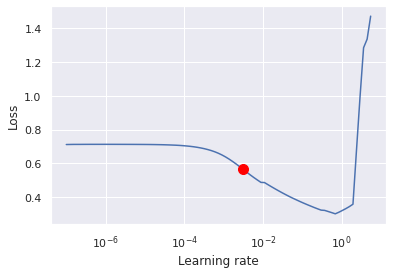

In [30]:
# Ensure Reproducibility
seed_everything(rand_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

best_model = None
oof_predictions = np.zeros((train_features.shape[0], len(train_classes)))
kfold_submit_preds = np.zeros((test_features.shape[0], len(train_classes)))
# for i, (train_index, val_index) in enumerate(
#         skf.split(train_features, train_labels[y_labels])):
for i in range(kfolds):
    train_index = folds[folds['kfold'] != i].index
    val_index = folds[folds['kfold'] == i].index

    if training_mode:
        print(f"Training on Fold {i} ......")
        print(train_index.shape, val_index.shape)

        logger = TensorBoardLogger(model_output_folder,
                                   name=f"fold{i}/logs",
                                   default_hp_metric=False)

        train = train_features.loc[train_index, all_features].copy().values
        fold_train_labels = train_labels.loc[train_index,
                                             train_classes].copy().values
        valid = train_features.loc[val_index, all_features].copy().values
        fold_valid_labels = train_labels.loc[val_index,
                                             train_classes].copy().values
        test = test_features[all_features].copy().values

        # LogScaler (Norm-2 Normalization)
        print("Running norm-2 normalization ......")
        train, valid, test, scaler = norm2_normalization(train, valid, test)
        save_pickle(scaler, model_output_folder, i, "log-scaler")

        # Extract DeepInsight Feature Map
        print("Extracting feature map ......")
        transformer = extract_feature_map(train,
                                          feature_extractor='tsne_exact',
                                          resolution=resolution,
                                          perplexity=perplexity)
        save_pickle(transformer, model_output_folder, i,
                    "deepinsight-transform")

        model = get_model(training_set=(train, fold_train_labels),
                          valid_set=(valid, fold_valid_labels),
                          test_set=test,
                          transformer=transformer)

        callbacks = [
            EarlyStopping(monitor='val_loss_epoch',
                          min_delta=1e-6,
                          patience=patience,
                          verbose=True,
                          mode='min',
                          strict=True),
            LearningRateMonitor(logging_interval='step')
        ]
        # https://pytorch-lightning.readthedocs.io/en/latest/generated/pytorch_lightning.callbacks.ModelCheckpoint.html#pytorch_lightning.callbacks.ModelCheckpoint
        checkpoint_callback = ModelCheckpoint(
            filepath=f"{model_output_folder}/fold{i}" +
            "/{epoch}-{train_loss_epoch:.6f}-{val_loss_epoch:.6f}" +
            f"-image_size={image_size}-resolution={resolution}-perplexity={perplexity}-fc={fc_size}",
            save_top_k=1,
            save_weights_only=False,
            save_last=False,
            verbose=True,
            monitor='val_loss_epoch',
            mode='min',
            prefix='')

        if debug_mode:
            # Find best LR
            # https://pytorch-lightning.readthedocs.io/en/latest/lr_finder.html
            trainer = Trainer(
                gpus=[gpus[0]],
                distributed_backend="dp",  # multiple-gpus, 1 machine
                auto_lr_find=True,
                benchmark=False,
                deterministic=True,
                logger=logger,
                accumulate_grad_batches=accumulate_grad_batches,
                gradient_clip_val=gradient_clip_val,
                precision=16,
                max_epochs=1)

            # Run learning rate finder
            lr_finder = trainer.tuner.lr_find(
                model,
                min_lr=1e-7,
                max_lr=1e2,
                num_training=100,
                mode='exponential',
                early_stop_threshold=100.0,
            )
            fig = lr_finder.plot(suggest=True)
            fig.show()

            # Pick point based on plot, or get suggestion
            suggested_lr = lr_finder.suggestion()

            # Update hparams of the model
            model.hparams.learning_rate = suggested_lr
            print(
                f"Suggested Learning Rate: {model.hparams.learning_rate:.6f}")

        else:
            trainer = Trainer(
                gpus=gpus,
                distributed_backend="dp",  # multiple-gpus, 1 machine
                max_epochs=epochs,
                benchmark=False,
                deterministic=True,
                # fast_dev_run=True,
                checkpoint_callback=checkpoint_callback,
                callbacks=callbacks,
                accumulate_grad_batches=accumulate_grad_batches,
                gradient_clip_val=gradient_clip_val,
                precision=16,
                logger=logger)
            trainer.fit(model)

            # Load best model
            seed_everything(rand_seed)
            best_model = MoAResNeSt.load_from_checkpoint(
                checkpoint_callback.best_model_path,
                pretrained_model_name=pretrained_model,
                training_set=(train, fold_train_labels),  # tuple
                valid_Set=(valid, fold_valid_labels),  # tuple
                test_set=test,
                transformer=transformer,
                fc_size=fc_size)
            best_model.freeze()

            print("Predicting on validation set ......")
            output = trainer.test(ckpt_path="best",
                                  test_dataloaders=model.val_dataloader(),
                                  verbose=False)[0]
            fold_preds = output["pred_probs"]
            oof_predictions[val_index, :] = fold_preds

            print(fold_preds[:5, :])
            fold_valid_loss = mean_logloss(fold_preds, fold_valid_labels)
            print(f"Fold {i} Validation Loss: {fold_valid_loss:.6f}")

            # Generate submission predictions
            print("Predicting on test set ......")
            best_model.setup()
            output = trainer.test(best_model, verbose=False)[0]
            submit_preds = output["pred_probs"]
            print(test_features.shape, submit_preds.shape)

            kfold_submit_preds += submit_preds / kfolds

        del model, trainer, train, valid, test, scaler, transformer
    else:
        print(f"Inferencing on Fold {i} ......")
        print(train_index.shape, val_index.shape)

        model_path = glob.glob(f'{model_output_folder}/fold{i}/epoch*.ckpt')[0]

        test = test_features[all_features].copy().values

        # Load LogScaler (Norm-2 Normalization)
        scaler = load_pickle(f'{model_output_folder}', i, "log-scaler")
        test = scaler.transform(test)

        # Load DeepInsight Feature Map
        transformer = load_pickle(f'{model_output_folder}', i,
                                  "deepinsight-transform")

        print(f"Loading model from {model_path}")
        model = get_model(training_set=(None, None),
                          valid_set=(None, None),
                          test_set=test,
                          transformer=transformer,
                          model_path=model_path)

        trainer = Trainer(
            logger=False,
            gpus=gpus,
            distributed_backend="dp",  # multiple-gpus, 1 machine
            precision=16,
            benchmark=False,
            deterministic=True)
        output = trainer.test(model, verbose=False)[0]
        submit_preds = output["pred_probs"]
        kfold_submit_preds += submit_preds / kfolds

        del model, trainer, scaler, transformer, test

    torch.cuda.empty_cache()
    gc.collect()

    if debug_mode:
        break

In [31]:
if training_mode:
    print(oof_predictions.shape)
else:
    oof_predictions = glob.glob(f'{model_output_folder}/../oof_*.npy')[0]
    oof_predictions = np.load(oof_predictions)

oof_loss = mean_logloss(oof_predictions,
                        train_labels[train_classes].values)
print(f"OOF Validation Loss: {oof_loss:.6f}")

(21948, 206)
OOF Validation Loss: 0.128674


In [32]:
# [ResNeSt]
# OOF Validation Loss: 0.014620
# "dropblock_prob":        0.0
# "fc_size":               512
# "final_drop":            0.0
# "learning_rate":         0.000352
# "num_classes":           206
# "pretrained_model_name": resnest50_fast_2s2x40d

In [33]:
if training_mode and best_model is not None:
    print(best_model.hparams)
    extra_params = {
        "gpus": len(gpus),
        # "pos_weight": True
    }
    exp_logger.experiment.add_hparams(hparam_dict={
        **dict(best_model.hparams),
        **extra_params
    },
                                      metric_dict={"oof_loss": oof_loss})

    oof_filename = "_".join(
        [f"{k}={v}" for k, v in dict(best_model.hparams).items()])
    with open(f'oof_{experiment_name}_{oof_loss}.npy', 'wb') as f:
        np.save(f, oof_predictions)

    with open(f'oof_{experiment_name}_{oof_loss}.npy', 'rb') as f:
        tmp = np.load(f)
        print(tmp.shape)

    # Rename model filename to remove `=` for Kaggle Dataset rule
    model_files = glob.glob(f'{model_output_folder}/fold*/epoch*.ckpt')
    for f in model_files:
        new_filename = f.replace("=", "")
        os.rename(f, new_filename)
        print(new_filename)

    del best_model
    torch.cuda.empty_cache()
    gc.collect()

## Submission

In [34]:
print(kfold_submit_preds.shape)

submission = pd.DataFrame(data=test_features["sig_id"].values,
                          columns=["sig_id"])
submission = submission.reindex(columns=["sig_id"] + train_classes)
submission[train_classes] = kfold_submit_preds
# Set control type to 0 as control perturbations have no MoAs
submission.loc[test_features['cp_type'] == 0, submission.columns[1:]] = 0
# submission.to_csv('submission.csv', index=False)
submission.to_csv('submission_resnest_v1.csv', index=False)

(3982, 206)


In [35]:
submission

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,adrenergic_receptor_antagonist,akt_inhibitor,aldehyde_dehydrogenase_inhibitor,alk_inhibitor,ampk_activator,analgesic,androgen_receptor_agonist,androgen_receptor_antagonist,anesthetic_-_local,angiogenesis_inhibitor,angiotensin_receptor_antagonist,anti-inflammatory,antiarrhythmic,antibiotic,anticonvulsant,antifungal,antihistamine,antimalarial,antioxidant,antiprotozoal,antiviral,apoptosis_stimulant,aromatase_inhibitor,atm_kinase_inhibitor,atp-sensitive_potassium_channel_antagonist,atp_synthase_inhibitor,atpase_inhibitor,atr_kinase_inhibitor,aurora_kinase_inhibitor,autotaxin_inhibitor,bacterial_30s_ribosomal_subunit_inhibitor,bacterial_50s_ribosomal_subunit_inhibitor,bacterial_antifolate,bacterial_cell_wall_synthesis_inhibitor,bacterial_dna_gyrase_inhibitor,bacterial_dna_inhibitor,bacterial_membrane_integrity_inhibitor,bcl_inhibitor,bcr-abl_inhibitor,benzodiazepine_receptor_agonist,beta_amyloid_inhibitor,bromodomain_inhibitor,btk_inhibitor,calcineurin_inhibitor,calcium_channel_blocker,cannabinoid_receptor_agonist,cannabinoid_receptor_antagonist,carbonic_anhydrase_inhibitor,casein_kinase_inhibitor,caspase_activator,catechol_o_methyltransferase_inhibitor,cc_chemokine_receptor_antagonist,cck_receptor_antagonist,cdk_inhibitor,chelating_agent,chk_inhibitor,chloride_channel_blocker,cholesterol_inhibitor,cholinergic_receptor_antagonist,coagulation_factor_inhibitor,corticosteroid_agonist,cyclooxygenase_inhibitor,cytochrome_p450_inhibitor,dihydrofolate_reductase_inhibitor,dipeptidyl_peptidase_inhibitor,diuretic,dna_alkylating_agent,dna_inhibitor,dopamine_receptor_agonist,dopamine_receptor_antagonist,egfr_inhibitor,elastase_inhibitor,erbb2_inhibitor,estrogen_receptor_agonist,estrogen_receptor_antagonist,faah_inhibitor,farnesyltransferase_inhibitor,fatty_acid_receptor_agonist,fgfr_inhibitor,flt3_inhibitor,focal_adhesion_kinase_inhibitor,free_radical_scavenger,fungal_squalene_epoxidase_inhibitor,gaba_receptor_agonist,gaba_receptor_antagonist,gamma_secretase_inhibitor,glucocorticoid_receptor_agonist,glutamate_inhibitor,glutamate_receptor_agonist,glutamate_receptor_antagonist,gonadotropin_receptor_agonist,gsk_inhibitor,hcv_inhibitor,hdac_inhibitor,histamine_receptor_agonist,histamine_receptor_antagonist,histone_lysine_demethylase_inhibitor,histone_lysine_methyltransferase_inhibitor,hiv_inhibitor,hmgcr_inhibitor,hsp_inhibitor,igf-1_inhibitor,ikk_inhibitor,imidazoline_receptor_agonist,immunosuppressant,insulin_secretagogue,insulin_sensitizer,integrin_inhibitor,jak_inhibitor,kit_inhibitor,laxative,leukotriene_inhibitor,leukotriene_receptor_antagonist,lipase_inhibitor,lipoxygenase_inhibitor,lxr_agonist,mdm_inhibitor,mek_inhibitor,membrane_integrity_inhibitor,mineralocorticoid_receptor_antagonist,monoacylglycerol_lipase_inhibitor,monoamine_oxidase_inhibitor,monopolar_spindle_1_kinase_inhibitor,mtor_inhibitor,mucolytic_agent,neuropeptide_receptor_antagonist,nfkb_inhibitor,nicotinic_receptor_agonist,nitric_oxide_donor,nitric_oxide_production_inhibitor,nitric_oxide_synthase_inhibitor,norepinephrine_reuptake_inhibitor,nrf2_activator,opioid_receptor_agonist,opioid_receptor_antagonist,orexin_receptor_antagonist,p38_mapk_inhibitor,p-glycoprotein_inhibitor,parp_inhibitor,pdgfr_inhibitor,pdk_inhibitor,phosphodiesterase_inhibitor,phospholipase_inhibitor,pi3k_inhibitor,pkc_inhibitor,potassium_channel_activator,potassium_channel_antagonist,ppar_receptor_agonist,ppar_receptor_antagonist,progesterone_receptor_agonist,progesterone_receptor_antagonist,prostaglandin_inhibitor,prostanoid_receptor_antagonist,proteasome_inhibitor,protein_kinase_inhibitor,protein_phosphatase_inhibitor,protein_synthesis_inhibitor,protein_tyrosine_kinase_inhibitor,radiopaque_medium,raf_inhibitor,ras_gtpase_inhib

In [36]:
torch.cuda.empty_cache()
gc.collect()

1946

## EOF